In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_with_weather.csv")
data.drop(['Month'], axis =1, inplace= True)
data.set_index("pickuptime", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

Time sequence 24hours(from 23 hours get 1 hours)

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 23

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exclude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 299) 26280 (26280,)
(26280, 23, 13) (26280,) (6516, 23, 13) (6516,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6516 samples
Epoch 1/100
 - 4s - loss: 0.1165 - val_loss: 0.0723
Epoch 2/100
 - 4s - loss: 0.0830 - val_loss: 0.0511
Epoch 3/100
 - 4s - loss: 0.0545 - val_loss: 0.0402
Epoch 4/100
 - 4s - loss: 0.0428 - val_loss: 0.0318
Epoch 5/100
 - 4s - loss: 0.0379 - val_loss: 0.0277
Epoch 6/100
 - 4s - loss: 0.0348 - val_loss: 0.0261
Epoch 7/100
 - 4s - loss: 0.0321 - val_loss: 0.0251
Epoch 8/100
 - 4s - loss: 0.0302 - val_loss: 0.0262
Epoch 9/100
 - 4s - loss: 0.0292 - val_loss: 0.0255
Epoch 10/100
 - 5s - loss: 0.0285 - val_loss: 0.0249
Epoch 11/100
 - 5s - loss: 0.0280 - val_loss: 0.0246
Epoch 12/100
 - 5s - loss: 0.0278 - val_loss: 0.0255
Epoch 13/100
 - 5s - loss: 0.0274 - val_loss: 0.0239
Epoch 14/100
 - 5s - loss: 0.0271 - val_loss: 0.0230
Epoch 15/100
 - 5s - loss: 0.0266 - val_loss: 0.0231
Epoch 16/100
 - 5s - loss: 0.0259 - val_loss: 0.0237
Epoch 17/100
 - 5s - loss: 0.0252 - val_loss: 0.0207
Epoch 18/100
 - 5s - loss: 0.0243 - val_loss: 0.0198
Epoch 

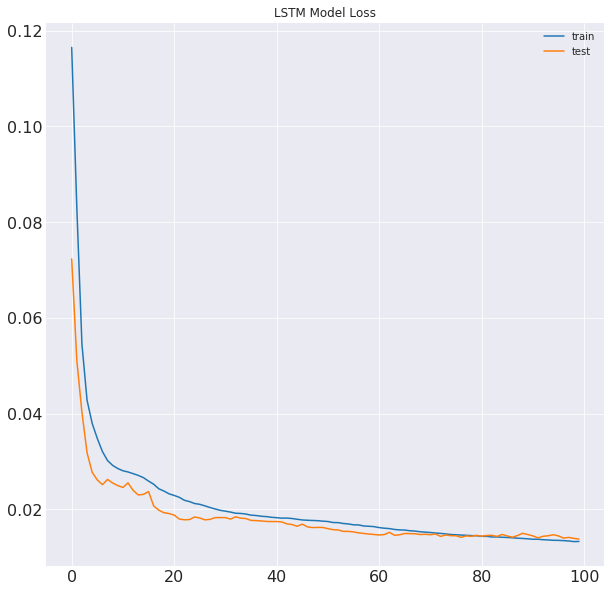

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast
inv_yhat = np.concatenate((test[:, 299:311], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 299:311], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9738795395206017
MAE:  773.33356
RMSE: 1063.9373806761373
mean absolute error percentage:  7.788607478141785


In [10]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 299:311], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 299:311], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9746553380965309
MAE:  985.631
RMSE: 1353.169427677111
mean absolute error percentage:  6.381148844957352


Time sequence 12hours(from 11 hours get 1 hours)

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 11

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exclude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 143) 26280 (26280,)
(26280, 11, 13) (26280,) (6540, 11, 13) (6540,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6540 samples
Epoch 1/100
 - 3s - loss: 0.1140 - val_loss: 0.0741
Epoch 2/100
 - 2s - loss: 0.0823 - val_loss: 0.0486
Epoch 3/100
 - 2s - loss: 0.0597 - val_loss: 0.0397
Epoch 4/100
 - 2s - loss: 0.0447 - val_loss: 0.0351
Epoch 5/100
 - 2s - loss: 0.0378 - val_loss: 0.0267
Epoch 6/100
 - 2s - loss: 0.0342 - val_loss: 0.0248
Epoch 7/100
 - 2s - loss: 0.0318 - val_loss: 0.0244
Epoch 8/100
 - 2s - loss: 0.0305 - val_loss: 0.0248
Epoch 9/100
 - 2s - loss: 0.0293 - val_loss: 0.0246
Epoch 10/100
 - 2s - loss: 0.0287 - val_loss: 0.0243
Epoch 11/100
 - 2s - loss: 0.0282 - val_loss: 0.0229
Epoch 12/100
 - 2s - loss: 0.0277 - val_loss: 0.0227
Epoch 13/100
 - 2s - loss: 0.0273 - val_loss: 0.0223
Epoch 14/100
 - 2s - loss: 0.0270 - val_loss: 0.0221
Epoch 15/100
 - 2s - loss: 0.0267 - val_loss: 0.0216
Epoch 16/100
 - 2s - loss: 0.0264 - val_loss: 0.0210
Epoch 17/100
 - 3s - loss: 0.0260 - val_loss: 0.0208
Epoch 18/100
 - 2s - loss: 0.0256 - val_loss: 0.0204
Epoch 

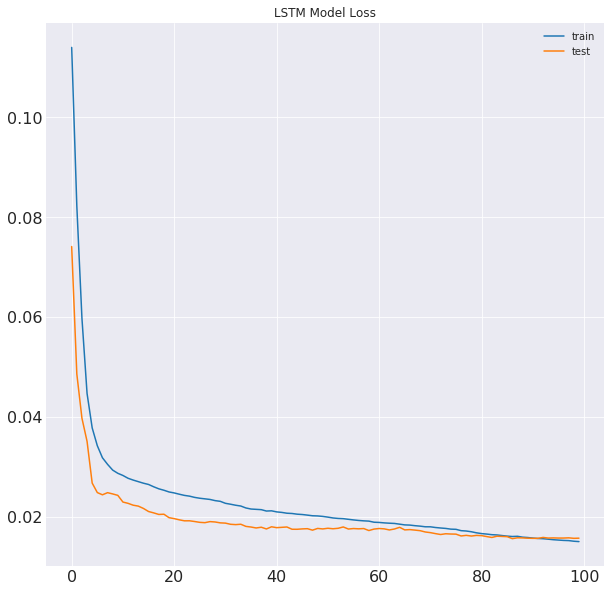

In [8]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [9]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast
inv_yhat = np.concatenate((test[:, 143:155], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 143:155], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9667680665517209
MAE:  880.8683
RMSE: 1199.4003189094124
mean absolute error percentage:  9.467047452926636


In [10]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat_t = np.concatenate((train[:, 143:155], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 143:155], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.954625607241119
MAE:  1296.6956
RMSE: 1811.0204305860275
mean absolute error percentage:  9.770796447992325


Time sequence 48hours(from 47 hours get 1 hours)

In [11]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [12]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [13]:
# split into train and test sets
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 611) 26280 (26280,)
(26280, 47, 13) (26280,) (6468, 47, 13) (6468,)


In [14]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6468 samples
Epoch 1/100
 - 11s - loss: 0.1150 - val_loss: 0.0643
Epoch 2/100
 - 10s - loss: 0.0736 - val_loss: 0.0384
Epoch 3/100
 - 10s - loss: 0.0482 - val_loss: 0.0370
Epoch 4/100
 - 10s - loss: 0.0392 - val_loss: 0.0367
Epoch 5/100
 - 10s - loss: 0.0360 - val_loss: 0.0368
Epoch 6/100
 - 10s - loss: 0.0334 - val_loss: 0.0299
Epoch 7/100
 - 10s - loss: 0.0309 - val_loss: 0.0261
Epoch 8/100
 - 10s - loss: 0.0288 - val_loss: 0.0252
Epoch 9/100
 - 10s - loss: 0.0273 - val_loss: 0.0230
Epoch 10/100
 - 10s - loss: 0.0261 - val_loss: 0.0227
Epoch 11/100
 - 10s - loss: 0.0252 - val_loss: 0.0228
Epoch 12/100
 - 12s - loss: 0.0243 - val_loss: 0.0210
Epoch 13/100
 - 10s - loss: 0.0235 - val_loss: 0.0214
Epoch 14/100
 - 13s - loss: 0.0232 - val_loss: 0.0207
Epoch 15/100
 - 10s - loss: 0.0229 - val_loss: 0.0197
Epoch 16/100
 - 10s - loss: 0.0226 - val_loss: 0.0195
Epoch 17/100
 - 10s - loss: 0.0223 - val_loss: 0.0197
Epoch 18/100
 - 10s - loss: 0.0221 - val_l

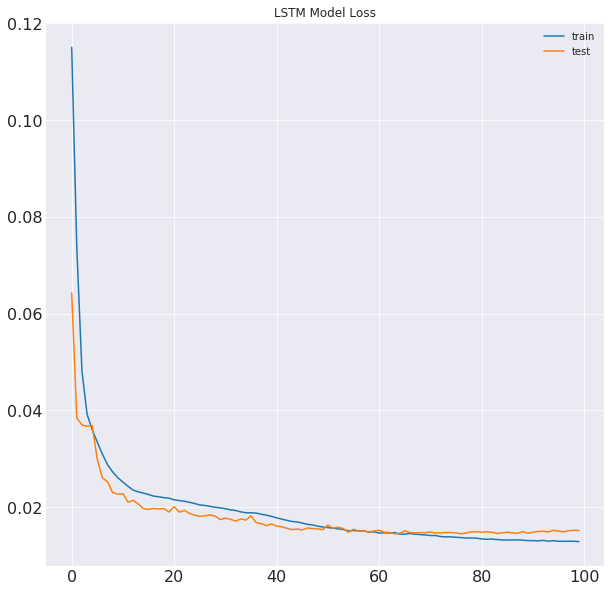

In [15]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [16]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast
inv_yhat = np.concatenate((test[:, 611:623], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 611:623], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.966848027534859
MAE:  851.581
RMSE: 1198.1744447283124
mean absolute error percentage:  8.372030407190323


In [17]:
#train error(bias)
yhat_t = model.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat_t = np.concatenate((train[:, 611:623], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 611:623], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9747489234082647
MAE:  985.81976
RMSE: 1350.8267375944258
mean absolute error percentage:  6.738167256116867
